<b><font size="6">Techscape Project</font><a class="anchor"><a id='toc'></a></b><br>

# Import the needed libraries

In [1]:
import pandas as pd
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
techscape = pd.read_csv('train.csv')
techscape.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [3]:
# Use this cell to check the values of each column 

#techscape.Date.value_counts()

# Check for missing data

In [31]:
techscape.info()

# There are now missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9857 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9857 non-null   string        
 1   Date                        9857 non-null   datetime64[ns]
 2   AccountMng_Pages            9857 non-null   int64         
 3   AccountMng_Duration         9857 non-null   float64       
 4   FAQ_Pages                   9857 non-null   int64         
 5   FAQ_Duration                9857 non-null   float64       
 6   Product_Pages               9857 non-null   int64         
 7   Product_Duration            9857 non-null   float64       
 8   GoogleAnalytics_BounceRate  9857 non-null   float64       
 9   GoogleAnalytics_ExitRate    9857 non-null   float64       
 10  GoogleAnalytics_PageValue   9857 non-null   float64       
 11  OS                          9857 non-null   string      

# Change the types of the variables

In [5]:
# ID does not make sense to be a int
techscape.Access_ID = techscape.Access_ID.astype('string') 

# Tranform Date into a datetime format
techscape.Date = pd.to_datetime(techscape.Date)

techscape.OS = techscape.OS.astype('string') 


techscape.Country = techscape.Country.astype('string') 


techscape.Type_of_Visitor = techscape.Type_of_Visitor.astype('string') 

techscape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Access_ID                   9999 non-null   string        
 1   Date                        9999 non-null   datetime64[ns]
 2   AccountMng_Pages            9999 non-null   int64         
 3   AccountMng_Duration         9999 non-null   float64       
 4   FAQ_Pages                   9999 non-null   int64         
 5   FAQ_Duration                9999 non-null   float64       
 6   Product_Pages               9999 non-null   int64         
 7   Product_Duration            9999 non-null   float64       
 8   GoogleAnalytics_BounceRate  9999 non-null   float64       
 9   GoogleAnalytics_ExitRate    9999 non-null   float64       
 10  GoogleAnalytics_PageValue   9999 non-null   float64       
 11  OS                          9999 non-null   string      

# Check for incoherencies in the data


In [6]:
# Date variable
print(f'Date of the web visit varies from {techscape.Date.min()} and {techscape.Date.max()}, excluding the month of April.')

Date of the web visit varies from 2020-02-01 00:00:00 and 2020-12-31 00:00:00, excluding the month of April.


In [7]:
# Pages and Duration variables

#techscape[(techscape['AccountMng_Pages']==0) & (techscape['AccountMng_Duration']!=0) ] # --> 0
account_index = techscape[(techscape['AccountMng_Pages']>1) & (techscape['AccountMng_Duration']==0) ].index  # --> 3
len(account_index)
techscape.drop(account_index, axis=0, inplace=True)
techscape

#techscape[(techscape['FAQ_Pages']==0) & (techscape['FAQ_Duration']!=0) ] # --> 0
faq_index = techscape[(techscape['FAQ_Pages']>1) & (techscape['FAQ_Duration']==0) ].index # --> 9
len(faq_index)
techscape.drop(faq_index, axis=0, inplace=True)
techscape

#techscape[(techscape['Product_Pages']==0) & (techscape['Product_Duration']!=0) ] # --> 0
product_index = techscape[(techscape['Product_Pages']>1) & (techscape['Product_Duration']==0) ].index # --> 130
len(product_index)
techscape.drop(product_index, axis=0, inplace=True)
techscape

# Total removed = 3 + 9 + 130 = 142

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,798279589,2020-05-08,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0
9995,798314158,2020-07-17,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0
9996,798339820,2020-03-23,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0
9997,798371242,2020-05-16,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0


# Deal with the outliers

In [37]:
# Se descriptive statistics for all the variables
techscape.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Access_ID,9857,9857,696169491,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,9857,305,2020-05-25 00:00:00,118,2020-02-01,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountMng_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,2.353454,3.352719,0.0,0.0,1.0,4.0,27.0
AccountMng_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,82.25781,180.712931,0.0,0.0,9.5,94.0,3398.75
FAQ_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,0.513442,1.28642,0.0,0.0,0.0,0.0,24.0
FAQ_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,35.05696,140.738449,0.0,0.0,0.0,0.0,2549.375
Product_Pages,9857.0,NaN,NaN,NaN,NaT,NaT,32.069494,44.734139,0.0,8.0,18.0,38.0,705.0
Product_Duration,9857.0,NaN,NaN,NaN,NaT,NaT,1215.786133,1967.220922,0.0,197.0,612.625,1483.55,63973.5222
GoogleAnalytics_BounceRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.020057,0.044845,0.0,0.0,0.0029,0.016,0.2
GoogleAnalytics_ExitRate,9857.0,NaN,NaN,NaN,NaT,NaT,0.041122,0.045789,0.0,0.0142,0.025,0.0481,0.2


In [38]:
#techscape[['AccountMng_Pages', 'FAQ_Pages', 'Product_Pages']].describe().T
#techscape[['AccountMng_Duration', 'FAQ_Duration', 'Product_Duration']].describe().T
#techscape[['GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Browser', 'Type_of_Traffic']].describe().T


# AccountMng_Pages appears to have outliers
# Same with FAQ_Pages
# Product_Pages definitely has outliers
# GoogleAnalytics_PageValue appears to have outliers

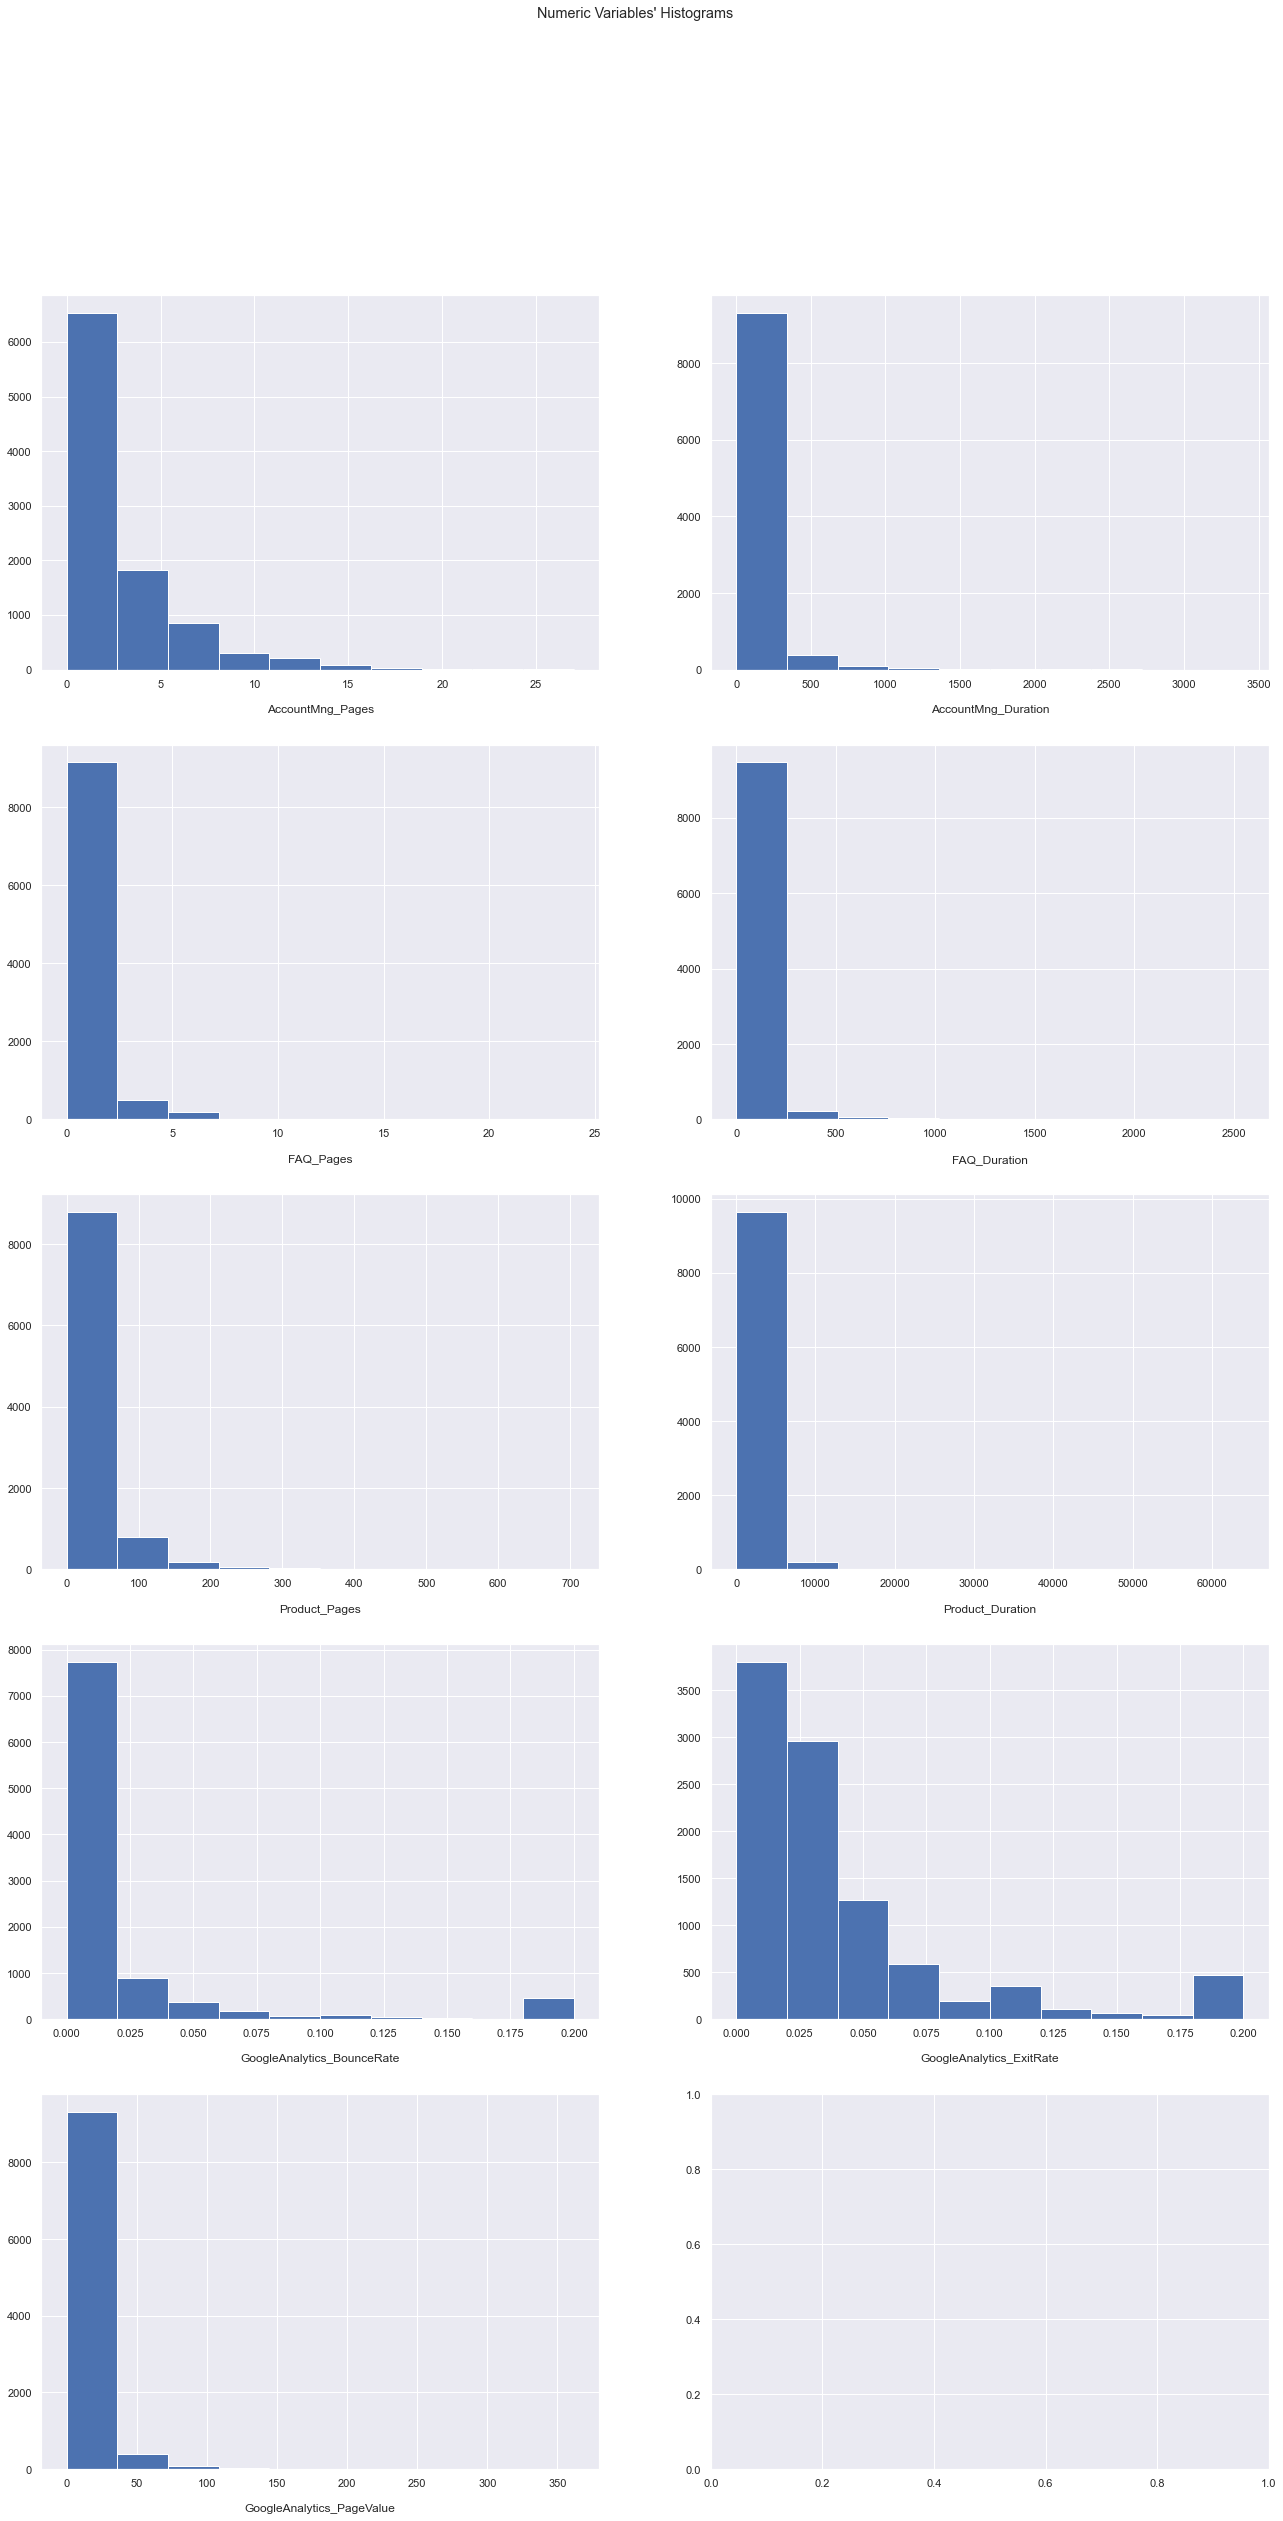

In [71]:
# -----------  Plot the histograms of the numeric variables  -----------

non_metric_features = ['Access_ID', 'Date',"OS", "Browser", "Country", "Type_of_Traffic", "Type_of_Visitor", 'Buy'] 
metric_features = techscape.columns.drop(non_metric_features).to_list()


# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(5, math.ceil(len(metric_features) / 5), figsize=(22, 40))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

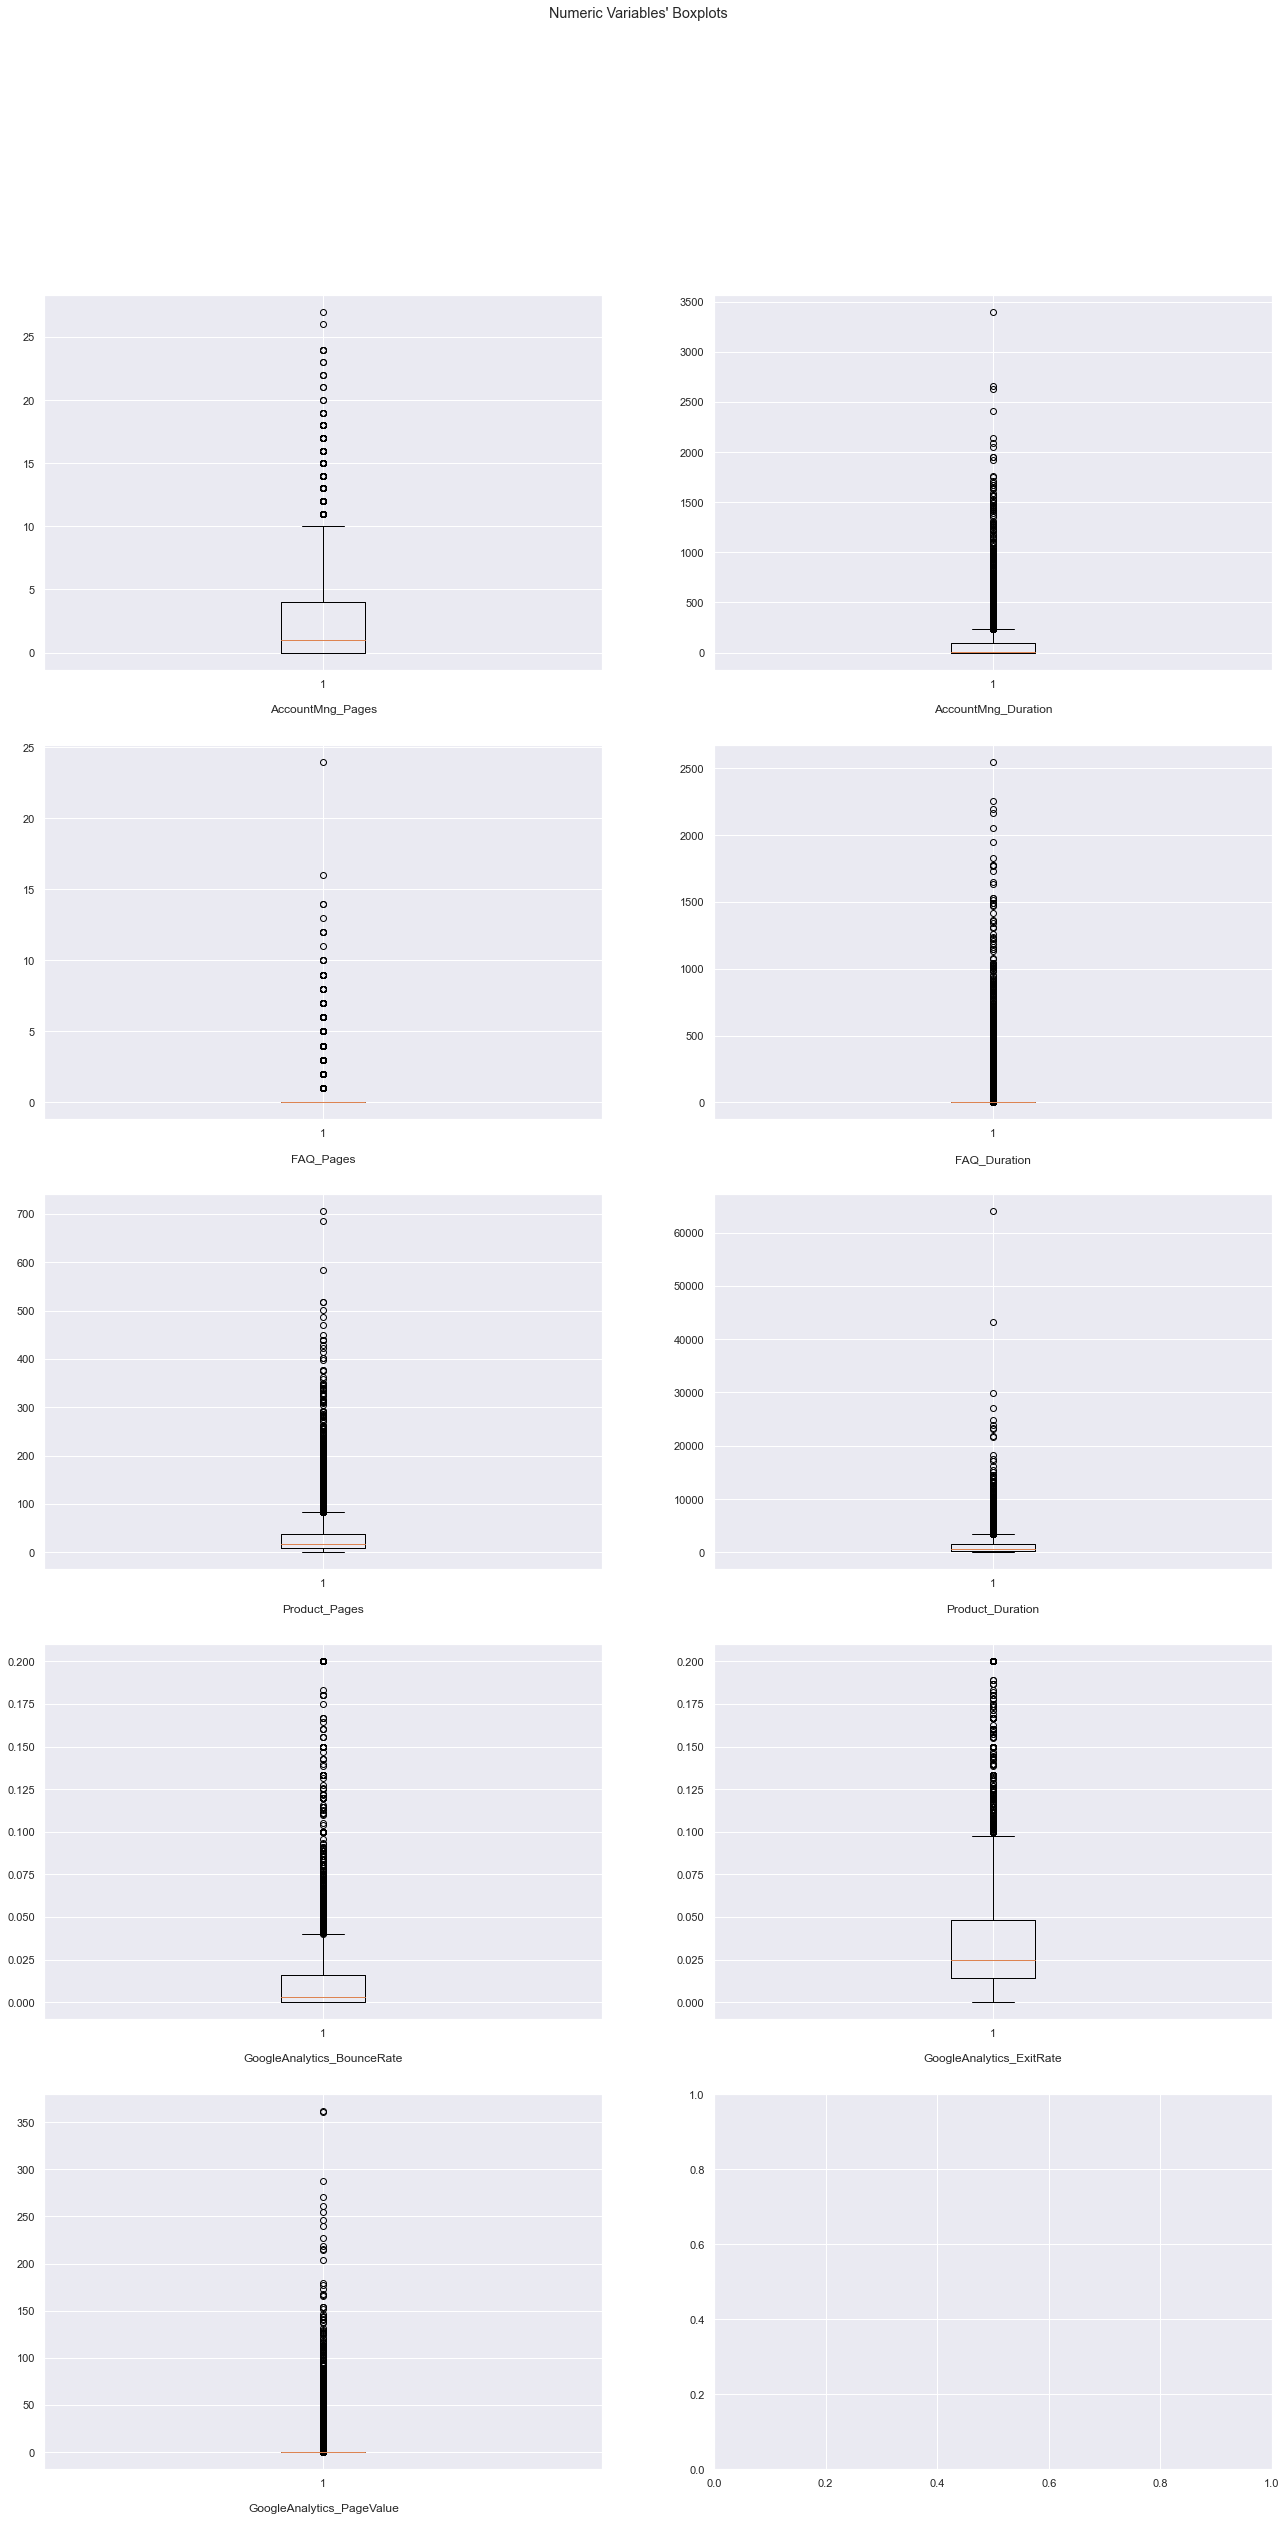

In [43]:
# -----------  Plot the boxplots of the numeric variables  -----------

# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(5, math.ceil(len(metric_features) / 5), figsize=(22, 40))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.boxplot(techscape[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Boxplots"

plt.suptitle(title)

plt.show()

In [47]:
# ------------------  Interquantile method ------------------

#hk_mean = df_tugas['HouseKeeping'].mean()
#hk_std = df_tugas['HouseKeeping'].std()
#
## Check for outliers: values that are more that 5 std away from the mean
## Try with different values of std because you cannot delet more than 3% of our dataset (75 observations in this case)
#df_tugas.loc[df_tugas['HouseKeeping'] > hk_mean + 2 * hk_std]


In [ ]:
# Percentage of ouliers removed: ___________


In [64]:
# -------------- DATA PARTITION --------------

# Define data as all the independent variables
data = techscape.drop(['Buy'], axis=1)
# Define target as the dependent variable
target = techscape['Buy']

# -----------------------

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, target, train_size=0.75, stratify = target, random_state=5)
# Train 0.75 || Valid 0.25
# Stratify so we have the same values in target in the train and val datasets

# -----------------------

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
# DO IT for validation
X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

In [50]:
# -------------- SCALLING --------------

from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler().fit(X_train_num)
#X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

## Convert the array to a pandas dataframe
#X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
#X_train_num_scaled.head(3)

#X_val_num_scaled = scaler.transform(X_val_num)
#X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
#X_val_num_scaled.head(3)

# Feature Selection

In [58]:
# Create new variables




In [59]:
# 1 - Filter methods

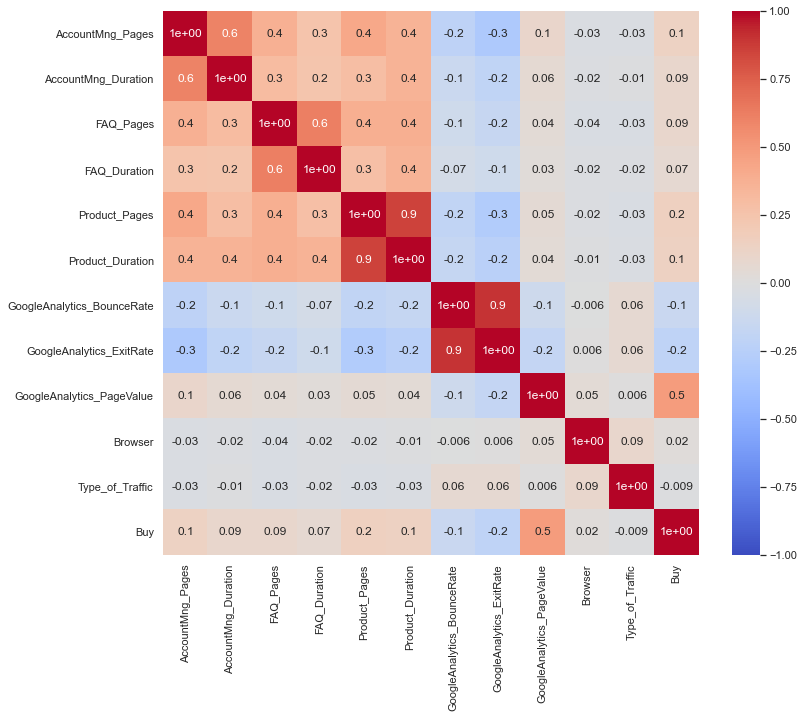

In [45]:
# Check correlations (numerical data)

all_train_num = X_train_num_scaled.join(y_train)
all_train_num.head()

corr = techscape.corr(method = 'pearson')  # or spearman

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, vmin=-1, vmax=1, annot = True, cmap ="coolwarm" , fmt='.1')

    plt.show()
    
cor_heatmap(corr)    

In [54]:
# Chi-Square for categorical data

X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)
    
    
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Access_ID is NOT an important predictor. (Discard Access_ID from model)
Date is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Visitor is IMPORTANT for Prediction


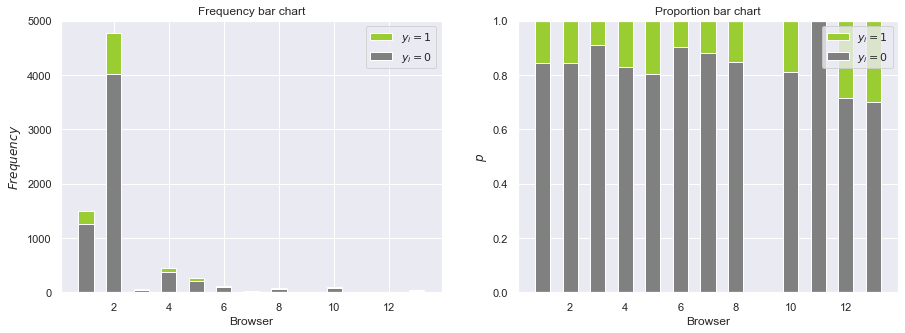

In [55]:
# Visualize weight of dependent variable in categorical data

# first join all the training data
all_train = X_train.join(y_train)


def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    #plt.xticks()
    plt.show()
    
bar_charts_categorical(all_train, "Browser", "Buy")

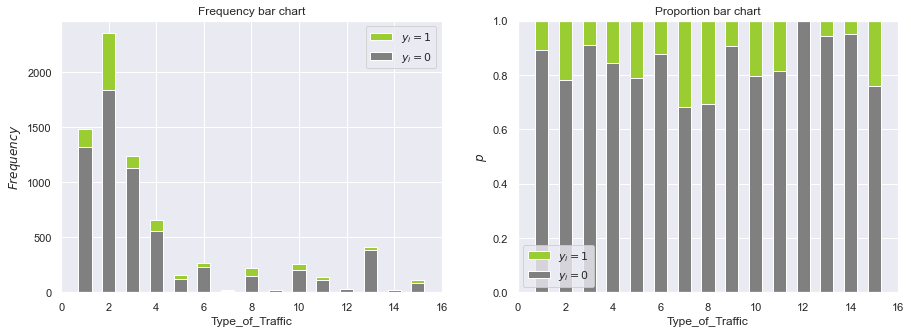

In [56]:
bar_charts_categorical(all_train, "Type_of_Traffic", "Buy")

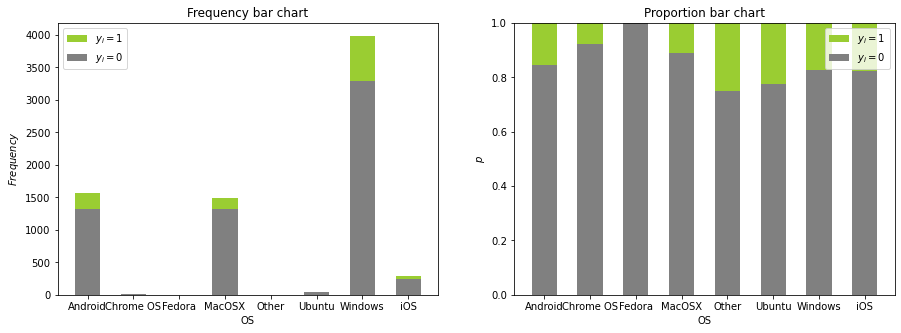

In [24]:
bar_charts_categorical(all_train, "OS", "Buy")

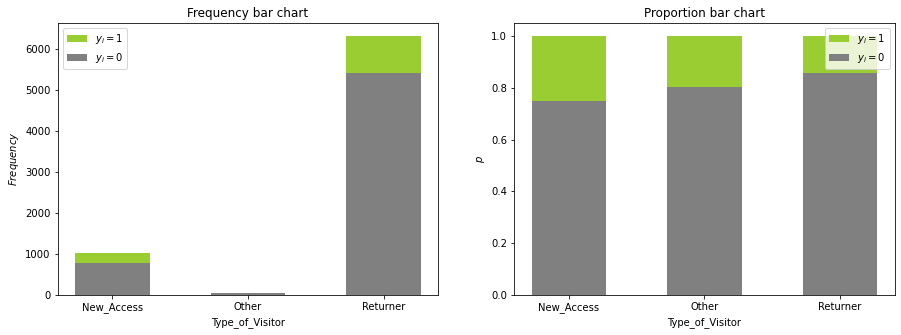

In [25]:
bar_charts_categorical(all_train, "Type_of_Visitor", "Buy")

In [ ]:
# ------------ 2- Wrapper methods (RFE) ------------

In [57]:
# ------------ 3- Embedded methods (Lasso Regression) ------------

In [ ]:
# Final insights !!





In [ ]:
# Model Evaluation and selection: (Lab class model selection)

# train/test/split:
# Training dataset, with 60% of the data, that will allow me to build the model;
# Validation dataset, with 20% of the data, that will allow me to fine tune the model and check some problems like overfitting;
# Test dataset, with 20% of the data, that will allow me to evaluate the performance of the final model.


# train/test/split vs K fold vs repeated k fold vs leave one out vs Stratified k-fold
# Ways of splitting the train/val/test datasets


# Model Selection
# Logistic vs Decision Trees vs Naive Bayes vs KNN

# Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression

# ????????????
#X_train['Date'] = pd.to_numeric(pd.to_datetime(X_train['Date']))
#
#log_model = LogisticRegression()
#log_model.fit(X_train, y_train)
#y_pred = log_model.predict(X_val)
#pred_prob = log_model.predict_proba(X_test)


In [ ]:
import sys
#!{sys.executable} -m pip install regressors
from regressors import stats

xlabels = X_train.columns
xlabels
print(log_model.coef_)
print(log_model.intercept_)

# Regression
stats.summary(clf = log_model, X = X_train, y = y_train)#, xlabels = xlabels)

In [ ]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

# Performance Measures

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [69]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [70]:
labels_train = log_model.predict(X_train)
labels_val = log_model.predict(X_val)

In [72]:
metrics(y_train=y_train, pred_train=labels_train , y_val=y_val, pred_val=labels_val)

NameError: name 'labels_train' is not defined

# Deployment

In [46]:
test = pd.read_csv('test.csv')
test.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.00,0,0.0,86,5332.5478,0.0139,0.0654,0.0000,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.50,0,0.0,55,1420.4725,0.0012,0.0058,0.0000,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.00,0,0.0,36,788.5000,0.0000,0.0250,0.0000,Windows,6,Spain,3,Returner
3,798760918,14-May-20,0,0.00,0,0.0,2,689.0000,0.0000,0.1000,0.0000,Windows,2,Spain,2,New_Access
4,798856982,5-Nov-20,12,225.25,1,0.0,129,3367.0413,0.0014,0.0185,1.0353,Windows,4,Portugal,10,Returner


In [ ]:
test['Buy'] = final_model.predict(test)

test['Buy'].value_counts()